In this tutorial, we will simulate a naive model of a micrograph. In particular, we will simulate a batch of images of the same particle at random poses, then sum over them.

The goal of this tutorial is to learn how to vmap in `cryojax`'s recommended pattern. This uses the lightweight wrappers around `equinox` in `cryojax`.

In [1]:
# Jax imports
import jax
import jax.numpy as jnp
import numpy as np

In [2]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryojax.simulator as cxs
from cryojax.data import read_array_with_spacing_from_mrc
from cryojax.rotations import SO3

First, we will build the image formation modeling components that we do not want to vmap over.

In [4]:
# First, load the scattering potential and projection method
filename = "./data/ribosome_4ug0_scattering_potential_from_cistem.mrc"
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
# ... now the projection method
projection_method = cxs.FourierSliceExtract(interpolation_order=1)
# ... and the contrast transfer theory
transfer_theory = cxs.ContrastTransferTheory(
    transfer_function=cxs.ContrastTransferFunction(
        defocus_u_in_angstroms=10000.0,
        defocus_v_in_angstroms=10000.0,
    )
)
# ... and the instrument
voltage_in_kilovolts = 300.0
instrument = cxs.Instrument(voltage_in_kilovolts)

# ... finally, the config
shape = (400, 600)
pixel_size = potential.voxel_size  # Angstroms
image_size = np.asarray(shape) * pixel_size
config = cxs.ImageConfig(shape, pixel_size, pad_scale=1.1)

Now we will construct an `ImagePipeline` by batching over a set of random number generator keys.

In [5]:
from functools import partial

import equinox as eqx
import equinox.internal as eqxi
from jaxtyping import PRNGKeyArray, PyTree


@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=eqxi.if_mapped(axis=0))
def make_pipeline(key: PRNGKeyArray, no_vmap: tuple[PyTree, ...]) -> cxs.ImagePipeline:
    config, potential, projection_method, instrument = no_vmap
    # ... instantiate rotations
    rotation = SO3.sample_uniform(key)
    # ... now in-plane translation
    ny, nx = config.shape
    in_plane_offset_in_angstroms = (
        jax.random.uniform(key, (2,), minval=-0.45, maxval=0.45)
        * jnp.asarray((nx, ny))
        * config.pixel_size
    )
    # ... convert 2D in-plane translation to 3D, setting the out-of-plane translation to
    # zero
    offset_in_angstroms = jnp.pad(in_plane_offset_in_angstroms, ((0, 1),))
    # ... build the pose
    pose = cxs.QuaternionPose.from_rotation_and_translation(
        rotation, offset_in_angstroms
    )
    # ... build the ensemble
    ensemble = cxs.BaseEnsemble(potential, pose)
    # ... and finally the scattering theory and return
    theory = cxs.LinearScatteringTheory(ensemble, projection_method, transfer_theory)
    return cxs.ImagePipeline(config, theory, instrument)

!!! info "What's with the `out_axes=eqxi.if_mapped(axis=0)`?"
    
    When we create a pytree with `eqx.filter_vmap` (or `jax.vmap`), `out_axes` should have the same structure as the output pytree. If `out_axes` is set to `None` at a particular leaf, this
    says that we do not want to broadcast that leaf (of course, this only works for unmapped leaves). By default `jax.vmap` sets `out_axes=0`, so all unmapped leaves get broadcasted. `equinox` allows us to pass `out_axes=eqxi.if_mapped(axes=0)`, which specifies *not* to broadcast pytree leaves unless the leaves are directly mapped.

    When building an `ImagePipeline`, it is very important that we do not broadcast arbitrary leaves! For example, an `ImageConfig` stores the coordinate systems for our image. Without the `out_axes=eqxi.if_mapped(axes=0)` specification, the `make_pipeline` would output an `ImagePipeline.config` whose coordinate systems have a batch dimension. This takes up unecessary memory.

In [6]:
# Generate RNG keys
number_of_poses = 20
keys = jax.random.split(jax.random.PRNGKey(12345), number_of_poses)

# ... instantiate the pipeline
pipeline = make_pipeline(keys, (config, potential, projection_method, instrument))

This may be a little odd at first. We have contructed a pipeline, where if we were to directly call its `render` method, it would not work. Think of it this way: because we created our `pipeline`s with a `vmap`, functions can now only be called after crossing `vmap` boundaries. There is very good reason for this! To learn more, read the section of the equinox documentation on [model ensembling](https://docs.kidger.site/equinox/tricks/#ensembling).

Now that we have an `ImagePipeline` with a batched set of poses, we need some way of telling our `vmap` exactly what pytree leaves have batch dimensions. One way `equinox` does this is by using pointers to particular pytree leaves to create what is called a `filter_spec`.

In [7]:
import cryojax as cx


# ... specify which leaves we would like to vmap over
where = lambda pipeline: pipeline.scattering_theory.potential_ensemble.pose
# ... use a cryojax wrapper to return a filter_spec
filter_spec = cx.get_filter_spec(pipeline, where)

AttributeError: 'ImagePipeline' object has no attribute 'specimen'

Here, `filter_spec` is a pytree of booleans of the same structure as `pipeline`. The values are `True` at leaves that we do want to `vmap` over and `False` where we don't. Filtered transformations are a cornerstone to `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/examples/frozen_layer/) in the equinox documentation for reading.

Above we have used a `cryojax` utility routine for creating a `filter_spec`, called `cryojax.get_filter_spec`. Next, we will finally define functions to batch and sum over images! To do this, we will again use a `cryojax` wrapper to `equinox` called `filter_vmap_with_spec`. This batches over a pytree, only at leaves specified by `filter_spec`. 

In [ ]:
import equinox as eqx


@partial(cx.filter_vmap_with_spec, filter_spec=filter_spec)
def compute_image_stack(pipeline):
    """Compute a batch of images at different poses,
    specified by the `filter_spec`.
    """
    image = pipeline.render()
    return image - image.mean()


@eqx.filter_jit
def compute_micrograph(pipeline):
    """Sum together the image stack."""
    return jnp.sum(compute_image_stack(pipeline), axis=0)

(<Figure size 550x550 with 2 Axes>,
 <Axes: title={'center': 'Image contrast for a sum of random poses'}>)

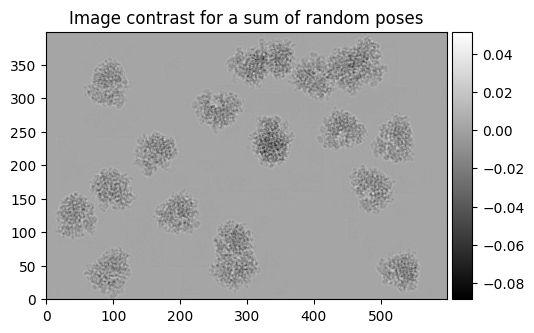

In [ ]:
# Compute the image and plot
fig, ax = plt.subplots(figsize=(5.5, 5.5))
micrograph = compute_micrograph(pipeline)
plot_image(
    micrograph,
    fig,
    ax,
    label="Image contrast for a sum of random poses",
    interpolation=None,
)

**What next?**

It is highly recommended to learn about about [pytree manipulation](https://docs.kidger.site/equinox/api/manipulation/) in equinox. In particular, read about [eqx.partition and eqx.combine](https://docs.kidger.site/equinox/api/manipulation/#equinox.partition). `cryojax` has made the choice to hide away some of these details with it's utility routines, but this is meant to just ease users into just using `equinox` for themselves.

This thread on the `equinox` github may also be useful: [https://github.com/patrick-kidger/equinox/issues/618](https://github.com/patrick-kidger/equinox/issues/618).